In [1]:
import sys
import argparse
import os
import numpy as np
import time
from glob import glob
from PIL import Image
from multiprocessing import Pool
from skimage import io
import h5py
import pickle
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sb
from sklearn.manifold import TSNE
from tqdm import tqdm

from mask_rbc import *

In [2]:
import MIA as MIA

FF = MIA.MIA_FEATURES

mask_rbc = wraper

from IPython.display import display
import matplotlib.pyplot as plt
from pylab import rcParams

want_to_label = False

def average_colour(image):
    x,y = np.where(np.mean(image,axis=2) > 0)
    return [image[x,y,0].mean(),
            image[x,y,1].mean(),
            image[x,y,2].mean()]

In [3]:
all_image_paths = glob("train/*png")
all_image_paths_fan = glob("training_fan_transformed/*png")

print(len(all_image_paths),len(all_image_paths_fan))

158 158


In [4]:
rcParams['figure.figsize'] = 16, 16

ss_size = 25

def fn(image):
    _,mask = mask_rbc(image)
    ret,labels = cv2.connectedComponents(mask[:,:,0])
    ss = np.arange(1,ret)
    new_mask = np.zeros_like(mask)
    if ss.shape[0] > ss_size:
        ss = np.random.choice(ss,ss_size,replace=False)
    for i in ss:
        new_mask[labels == i,:] = 255
    features = MIA.wrapper(image,new_mask)
    return features

def watershed_contours(contours,image):
    shape = image.shape[:2]
    kernel = np.ones((3,3))
    binary_image = np.zeros(shape,np.uint8)
    cv2.drawContours(binary_image,contours,-1,255,cv2.FILLED)

    D = ndimage.distance_transform_edt(binary_image)
    binary_image = cv2.morphologyEx(binary_image,cv2.MORPH_OPEN,kernel)
    
    localMax = peak_local_max(D, indices=False,
                              min_distance=15,labels=binary_image)
    markers = ndimage.label(localMax, structure=np.ones((3,3)))[0]
    labels = watershed(-D, markers,
                       mask=binary_image,
                       connectivity=4)
    mask = labels > 0
    mask[mask == -1] = 0
    e = np.uint8(filters.sobel(labels > 0)>0)*255
    mask = np.uint8(mask) * 255 - e
    contours = cv2.findContours(mask.copy(),
                                cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)[-2]
    return contours

def get_edges(img):
    otsu_img = cv2.dilate(otsu_threshold(img),kernel=np.ones((3,3)))
    otsu_img = otsu_threshold(img)
    img = np.uint8(gamma_stretching(img,5) * 255)
    img = linear_stretching(img)
    img = cv2.medianBlur(img,5)
    img = cv2.GaussianBlur(img,(3,3),1)
    img = -cv2.bilateralFilter(img,11,5,10)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(img,50,150)
    edges = cv2.dilate(edges,kernel=np.ones((5,5)),iterations=1)
    edges = cv2.erode(edges,kernel=np.ones((3,3)),iterations=1)
    edges = np.where(edges > 0,1,0)
    edges_otsu = edges * otsu_img
    if edges_otsu.max() - edges_otsu.min() != 0:
        edges = linear_stretching(edges_otsu)
    return edges

def mask_rbc(image):
    image[image < 0] = 0
    edge_image = get_edges(image)
    contours = get_contours(edge_image)
    contour_image = np.zeros_like(image)
    cv2.drawContours(image=contour_image,
                     contours=contours,
                     contourIdx=-1,
                     color=(255,255,255),
                     thickness=-1)
    contour_image = contour_image[:,:,0] - edge_image
    contours = get_contours(contour_image)
    contours_filtered = filter_contours_size_color_2(contours,8,300,2000,image)
    fitted_ellipses = fit_ellipse(contours_filtered)
    filtered_ellipses,filtered_contours = filter_ellipse_size(
        fitted_ellipses,contours_filtered,1.5,300,1500)
    contour_image = np.zeros_like(image)
    cv2.drawContours(image=contour_image,
                     contours=filtered_contours,
                     contourIdx=-1,
                     color=(255,255,255),
                     thickness=-1)
    return image,contour_image

file_name = "all_characterised_cells.pkl"
if os.path.exists(file_name) == False:
    all_cells = []
    cell_idx = 0
    for image_path in tqdm(all_image_paths):
        image = io.imread(image_path)
        features = fn(image)
        for cell in features:
            cell['isolated_image'] = np.uint8(cell['isolated_image'])
            cell['image'] = np.uint8(cell['image'] * 255)
            cell['image_path'] = image_path
            cell['cell_idx'] = cell_idx
            cell['center_x'] = np.mean(cell['x'])
            cell['center_y'] = np.mean(cell['y'])
            del cell['x']
            del cell['y']
            cell_idx += 1
        all_cells.extend(features)
        del image, features
    with open(file_name,"wb") as o:
        pickle.dump(all_cells,o)
else:
    with open(file_name,"rb") as o:
        all_cells = pickle.load(o)

In [5]:
file_name = "all_characterised_cells_fan.pkl"
if os.path.exists(file_name) == False:
    all_cells_fan = []
    cell_idx = 0
    for image_path in tqdm(all_image_paths_fan):
        image = io.imread(image_path)
        features = fn(image)
        for cell in features:
            cell['isolated_image'] = np.uint8(cell['isolated_image'])
            cell['image'] = np.uint8(cell['image'] * 255)
            cell['image_path'] = image_path
            cell['cell_idx'] = cell_idx
            cell['center_x'] = np.mean(cell['x'])
            cell['center_y'] = np.mean(cell['y'])
            del cell['x']
            del cell['y']
            cell_idx += 1
        all_cells_fan.extend(features)
        del image, features
    with open(file_name,"wb") as o:
        pickle.dump(all_cells_fan,o)
else:
    with open(file_name,"rb") as o:
        all_cells_fan = pickle.load(o)

In [6]:
for cell in all_cells:
    image = cell['isolated_image']
    grey_image = cell['isolated_image'].mean(axis=-1)
    idxs = grey_image > 0
    
    all_histograms = []
    for i in range(0,3):
        histogram,_ = np.histogram(
            image[:,:,i][idxs], 
            bins=5, range=(0, 256))
        histogram = histogram / histogram.sum()
        all_histograms.append(histogram)

    cell['histogram'] = np.concatenate(all_histograms)

In [7]:
all_features = []
for cell in all_cells:
    try:
        features = [cell[f] for f in FF]
        all_features.append(features)
    except:
        all_features.append([np.nan for _ in FF])

all_features = np.array(all_features)
all_features = all_features[np.all(~np.isnan(all_features),axis=1),:]
all_features = all_features[np.all(~np.isinf(all_features),axis=1),:]

all_features.shape

(3509, 42)

In [8]:
all_features_fan = []
for cell in all_cells_fan:
    try:
        features = [cell[f] for f in FF]
        all_features_fan.append(features)
    except:
        all_features_fan.append([np.nan for _ in FF])

all_features_fan = np.array(all_features_fan)
all_features_fan = all_features_fan[np.all(~np.isnan(all_features_fan),axis=1),:]
all_features_fan = all_features_fan[np.all(~np.isinf(all_features_fan),axis=1),:]

all_features_fan.shape

(3582, 42)

## Match cells between datasets

In [9]:
from scipy.spatial.distance import cdist

match_dict = {}
cell_idx_dict = {}
for cell in all_cells:
    P = os.path.split(cell['image_path'])[-1]
    if P not in match_dict:
        match_dict[P] = [(cell['center_x'],cell['center_y'])]
        cell_idx_dict[P] = [cell['cell_idx']]
    else:
        match_dict[P].append((cell['center_x'],cell['center_y']))
        cell_idx_dict[P].append(cell['cell_idx'])
        
match_dict_fan = {}
cell_idx_dict_fan = {}
for cell in all_cells_fan:
    P = os.path.split(cell['image_path'])[-1][11:]
    if P not in match_dict_fan:
        match_dict_fan[P] = [(cell['center_x'],cell['center_y'])]
        cell_idx_dict_fan[P] = [cell['cell_idx']]
    else:
        match_dict_fan[P].append((cell['center_x'],cell['center_y']))
        cell_idx_dict_fan[P].append(cell['cell_idx'])
        
cell_idx_matching = {}
for k in match_dict:
    if k in match_dict_fan:
        A = np.array(match_dict[k])
        B = np.array(match_dict_fan[k])
        dist_matrix = cdist(A,B)
        
        A_idx,B_idx = np.where(dist_matrix < 1)
        for i in range(A_idx.size):
            idx = cell_idx_dict[k][i]
            idx_fan = cell_idx_dict_fan[k][i]
            cell_idx_matching[idx] = idx_fan

## Model training

In [10]:
unique_paths = [c['image_path'] for c in all_cells]
unique_paths = list(set(unique_paths))
training_paths = np.random.choice(
    unique_paths,int(len(unique_paths)*0.7),replace=False)
testing_paths = [x for x in unique_paths if x not in training_paths]

unique_paths_fan = [c['image_path'] for c in all_cells_fan]
unique_paths_fan = list(set(unique_paths_fan))
training_paths_fan = np.random.choice(
    unique_paths_fan,int(len(unique_paths_fan)*0.7),replace=False)
testing_paths_fan = [x for x in unique_paths_fan if x not in training_paths_fan]

labelled_test_set = {
    'classification':[],
    'cell_idx':[]
}
try:
    with open('test_set.pkl','rb') as o:
        store_dict = pickle.load(o)
        for i,c in zip(store_dict["cell_idx"],store_dict["classification"]):
            labelled_test_set["cell_idx"].append(i)
            labelled_test_set["classification"].append(c)
        print("loaded")
except:
    pass

print(len(training_paths),len(testing_paths))

loaded
109 48


### Labelling testing set

I am setting a threshold of 100 per loop to keep it less tiring to label cells.

In [11]:
if want_to_label == True:
    ss = [c['cell_idx'] for c in all_cells if c['image_path'] in testing_paths]
    ss = [i for i in ss if i not in labelled_test_set['cell_idx']]
    print("Labelled: {}; missing: {}".format(len(labelled_test_set['cell_idx']),len(ss)))
    for i in np.random.choice(ss,np.minimum(100,len(ss)),replace=False):
        cell = all_cells[i]
        display(Image.fromarray(cell['isolated_image']))
        classification = input()
        if classification == '':
            classification = 1
        labelled_test_set['classification'].append(classification)
        labelled_test_set['cell_idx'].append(i)

    print(len(labelled_test_set['cell_idx']))

#### Double check

In [12]:
checked = []

In [13]:
if want_to_label == True:
    if len(checked) > 10:
        checked = checked[:-3]
    for i,(idx,c) in enumerate(zip(labelled_test_set['cell_idx'],labelled_test_set['classification'])):
        if idx not in checked and str(c) == "0":
            cell = all_cells[idx]
            display("{}/{} - {}".format(i+1,len(labelled_test_set['cell_idx']),c))
            display(Image.fromarray(cell['isolated_image']))
            classification = input()
            if classification == '':
                pass
            else:
                labelled_test_set['classification'][i] = classification
            checked.append(idx)

    for i,(idx,c) in enumerate(zip(labelled_test_set['cell_idx'],labelled_test_set['classification'])):
        if idx not in checked and str(c) == "1":
            cell = all_cells[idx]
            display("{}/{} - {}".format(i+1,len(labelled_test_set['cell_idx']),c))
            display(Image.fromarray(cell['isolated_image']))
            classification = input()
            if classification == '':
                pass
            else:
                labelled_test_set['classification'][i] = classification
            checked.append(idx)

In [14]:
store_dict = {k:[] for k in ["cell_idx","classification",*all_cells[0].keys()]}

for i,(idx,c) in enumerate(zip(labelled_test_set['cell_idx'],labelled_test_set['classification'])):
    try:
        cell = all_cells[idx]
        store_dict['classification'].append(c)
        for k in cell:
            store_dict[k].append(cell[k])
    except:
        pass
        
with open("test_set.pkl","wb") as o:
    pickle.dump(store_dict,o)

### Labelling/training of training set (bootstrapping classifications)

#### Initial labelling

In [15]:
labelled_train_set = {
    'classification':[],
    'cell_idx':[]
}
try:
    with open('train_set.pkl','rb') as o:
        store_dict = pickle.load(o)
        labelled_train_set = {'classification':[],
                              'cell_idx':[]}
        for i,c in zip(store_dict["cell_idx"],store_dict["classification"]):
            labelled_train_set["cell_idx"].append(i)
            labelled_train_set["classification"].append(c)
        print("loaded")
except:
    pass

loaded


In [16]:
if want_to_label == True:
    labelled_train_set['classification'] = labelled_train_set['classification'][:-1]
    labelled_train_set['cell_idx'] = labelled_train_set['cell_idx'][:-1]

    ss = [c['cell_idx'] for c in all_cells if c['image_path'] in training_paths]
    ss = [i for i in ss if i not in labelled_train_set['cell_idx']]

    del classification
    for i in np.random.choice(ss,100,replace=False):
        cell = all_cells[i]
        display(Image.fromarray(cell['isolated_image']))
        classification = input()
        if classification == '':
            classification = 1
        labelled_train_set['classification'].append(classification)
        labelled_train_set['cell_idx'].append(i)

    print(len(labelled_train_set['cell_idx']))

In [17]:
checked = []

In [18]:
if want_to_label == True:
    if len(checked) > 10:
        checked = checked[:-3]
    for i,(idx,c) in enumerate(zip(labelled_train_set['cell_idx'],labelled_train_set['classification'])):
        if idx not in checked and str(c) == "0":
            cell = all_cells[idx]
            display("{}/{} - {}".format(i+1,len(labelled_train_set['cell_idx']),c))
            display(Image.fromarray(cell['isolated_image']))
            classification = input()
            if classification == '':
                pass
            else:
                labelled_train_set['classification'][i] = classification
            checked.append(idx)

    for i,(idx,c) in enumerate(zip(labelled_train_set['cell_idx'],labelled_train_set['classification'])):
        if idx not in checked and str(c) == "1" or str(c) == '-':
            cell = all_cells[idx]
            display("{}/{} - {}".format(i+1,len(labelled_train_set['cell_idx']),c))
            display(Image.fromarray(cell['isolated_image']))
            classification = input()
            if classification == '':
                pass
            else:
                labelled_train_set['classification'][i] = classification
            checked.append(idx)

In [19]:
store_dict = {k:[] for k in ["cell_idx","classification",*all_cells[0].keys()]}

for i,(idx,c) in enumerate(zip(labelled_train_set['cell_idx'],labelled_train_set['classification'])):
    try:
        cell = all_cells[idx]
        store_dict['classification'].append(c)
        for k in cell:
            store_dict[k].append(cell[k])
    except:
        pass
        
with open("train_set_safekeeping.pkl","wb") as o:
    pickle.dump(store_dict,o)

#### Initial training

In [58]:
standardized_scaller = StandardScaler()

training_X = []
training_y = []
for i,c in zip(labelled_train_set['cell_idx'],labelled_train_set['classification']):
    try:
        features = [all_cells[i][f] for f in FF]
        training_X.append(features)
        if c == '':
            c = '1'
        training_y.append(c)
    except:
        pass
    
training_X = np.array(training_X)
training_y = np.array(training_y).astype(np.bool)

xgb_classifier = xgb.XGBClassifier(
    booster="dart",
    eval_metric="logloss",
    scale_pos_weight=1-np.sum(training_y==0)/len(training_y))

standardized_scaller = standardized_scaller.fit(training_X)
training_X = standardized_scaller.transform(training_X)
fitted_model = xgb_classifier.fit(training_X,training_y)

predictions = fitted_model.predict(training_X)

print(metrics.classification_report(training_y,predictions))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

       False       1.00      1.00      1.00       392
        True       1.00      1.00      1.00      1870

   micro avg       1.00      1.00      1.00      2262
   macro avg       1.00      1.00      1.00      2262
weighted avg       1.00      1.00      1.00      2262



In [59]:
np.sum(training_y==0)/training_y.size

0.17329796640141468

#### Second round (labelling + training)

In [22]:
if want_to_label == True:
    labelled_train_set['classification'] = labelled_train_set['classification'][:-1]
    labelled_train_set['cell_idx'] = labelled_train_set['cell_idx'][:-1]
    print(len(labelled_train_set['classification']))

In [23]:
if want_to_label == True:
    ss = [c['cell_idx'] for c in all_cells if c['image_path'] in training_paths]
    ss = [i for i in ss if i not in labelled_train_set['cell_idx']]

    for i in np.random.choice(ss,100,replace=False):
        cell = all_cells[i]
        features = np.array([all_cells[i][f] for f in FF])[np.newaxis,:]
        features = standardized_scaller.transform(features)
        predicted_proba = fitted_model.predict_proba(features)
        predicted_class = str(int(fitted_model.predict(features)))
        if predicted_proba[:,1] > 0.1 and predicted_proba[:,1] < 0.9:
            print('Predicted class:',predicted_class,predicted_proba[:,1])
            display(Image.fromarray(cell['isolated_image']))
            classification = input()
            if classification == '':
                classification = predicted_class
            labelled_train_set['classification'].append(classification)
            labelled_train_set['cell_idx'].append(i)

In [24]:
xgb_classifier = xgb.XGBClassifier(
    booster="dart",
    eval_metric="logloss",
    scale_pos_weight=10)


training_X = []
training_y = []
for i,c in zip(labelled_train_set['cell_idx'],labelled_train_set['classification']):
    try:
        features = [all_cells[i][f] for f in FF]
        features.extend(average_colour(all_cells[i]['isolated_image']))
        training_X.append(features)

        if c == '':
            c = '1'
        training_y.append(c)
    except:
        pass

training_X = np.array(training_X)
training_y = np.array(training_y).astype(np.bool)

standardized_scaller = standardized_scaller.fit(training_X)
training_X = standardized_scaller.transform(training_X)
fitted_model = xgb_classifier.fit(training_X,training_y)

predictions = fitted_model.predict(training_X)

print("Accuracy",metrics.accuracy_score(training_y,predictions))
print("F1-score",metrics.f1_score(training_y,predictions))
print(metrics.confusion_matrix(training_y,predictions))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy 1.0
F1-score 1.0
[[ 392    0]
 [   0 1870]]


In [25]:
store_dict = {k:[] for k in ["cell_idx","classification",*all_cells[0].keys()]}

for i,(idx,c) in enumerate(zip(labelled_train_set['cell_idx'],labelled_train_set['classification'])):
    try:
        cell = all_cells[idx]
        store_dict['classification'].append(c)
        for k in cell:
            store_dict[k].append(cell[k])
    except:
        pass
        
with open("train_set.pkl","wb") as o:
    pickle.dump(store_dict,o)

### Testing the model

In [26]:
training_X = []
training_y = []
for i,c in zip(labelled_train_set['cell_idx'],labelled_train_set['classification']):
    try:
        features = [all_cells[i][f] for f in FF]
        training_X.append(features)

        if c == '':
            c = '1'
        training_y.append(c)
    except:
        pass
    
training_X = np.array(training_X)
training_y = np.array(training_y).astype(np.bool)

In [60]:
training_X = []
training_y = []
f_idx = [0,42]
for i,c in zip(labelled_train_set['cell_idx'],labelled_train_set['classification']):
    try:
        features = [all_cells[i][f] for f in FF]
        training_X.append(features)

        if c == '':
            c = '1'
        training_y.append(c)
    except:
        pass
    
training_X = np.array(training_X)
training_y = np.array(training_y).astype(np.bool)

xgb_classifier = xgb.XGBClassifier(
    booster="dart",
    eval_metric="logloss",
    scale_pos_weight=10
)

standardized_scaller = standardized_scaller.fit(training_X)
training_X = standardized_scaller.transform(training_X)
fitted_model = xgb_classifier.fit(training_X,training_y)

testing_X = []
testing_y = []
for i,c in zip(labelled_test_set['cell_idx'],labelled_test_set['classification']):
    try:
        features = [all_cells[i][f] for f in FF]
        testing_X.append(features)
        if c == '':
            c = '1'
        testing_y.append(int(c))
    except:
        pass
    
testing_X = np.array(testing_X)
testing_y = np.array(testing_y).astype(np.bool)

testing_X = standardized_scaller.transform(testing_X)

predictions = fitted_model.predict(testing_X)

print("Accuracy",metrics.accuracy_score(testing_y,predictions))
print("F1-score",metrics.f1_score(testing_y,predictions))
print(metrics.confusion_matrix(testing_y,predictions))
print(metrics.classification_report(testing_y,predictions))
print(np.sum(training_y == 1),training_y.shape)
print(np.sum(testing_y == 1),testing_y.shape)

tp,fp,fn,tn = metrics.confusion_matrix(testing_y,predictions).ravel()

print("Specificity",tn/(fp+tn))

scalerfile = 'scaler'
pickle.dump(standardized_scaller, open(scalerfile, 'wb'))
fitted_model.save_model("xgb_model")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy 0.9774164408310749
F1-score 0.9870533402382186
[[129  16]
 [  9 953]]
              precision    recall  f1-score   support

       False       0.93      0.89      0.91       145
        True       0.98      0.99      0.99       962

   micro avg       0.98      0.98      0.98      1107
   macro avg       0.96      0.94      0.95      1107
weighted avg       0.98      0.98      0.98      1107

1870 (2262,)
962 (1107,)
Specificity 0.9834881320949432


In [28]:
fitted_model = xgb.XGBClassifier(
    n_estimators=50,
    eval_metric="logloss",
    scale_pos_weight=10
)

with open("scaler","rb") as o:
    standardized_scaller = pickle.load(o)
fitted_model.load_model("xgb_model")

testing_X = []
testing_y = []
for i,c in zip(labelled_test_set['cell_idx'],labelled_test_set['classification']):
    try:
        features = [all_cells[i][f] for f in FF]
        testing_X.append(features)
        if c == '':
            c = '1'
        testing_y.append(int(c))
    except:
        pass
    
testing_X = np.array(testing_X)
testing_y = np.array(testing_y).astype(np.bool)

testing_X = standardized_scaller.transform(testing_X)

predictions = fitted_model.predict(testing_X)
print(predictions)

print("Accuracy",metrics.accuracy_score(testing_y,predictions))
print("F1-score",metrics.f1_score(testing_y,predictions))
print(metrics.confusion_matrix(testing_y,predictions))
print(metrics.classification_report(testing_y,predictions))

[ True False False ... False False  True]
Accuracy 0.9774164408310749
F1-score 0.9870533402382186
[[129  16]
 [  9 953]]
              precision    recall  f1-score   support

       False       0.93      0.89      0.91       145
        True       0.98      0.99      0.99       962

   micro avg       0.98      0.98      0.98      1107
   macro avg       0.96      0.94      0.95      1107
weighted avg       0.98      0.98      0.98      1107



In [29]:
scaler_parameters = {
    "mean":standardized_scaller.mean_,
    "std":standardized_scaller.scale_
}
standardized_scaller.mean_ = scaler_parameters["mean"]
pickle.dump(scaler_parameters, open("scaler_params", 'wb'))

## Training FAN-transformed model

### Labelling data

#### Training

In [30]:
want_to_label = False

labelled_train_set_fan = {
    'classification':[],
    'cell_idx':[]
}
try:
    with open('train_set_fan.pkl','rb') as o:
        store_dict = pickle.load(o)
        labelled_train_set_fan = {'classification':[],
                                  'cell_idx':[]}
        for i,c in zip(store_dict["cell_idx"],store_dict["classification"]):
            labelled_train_set_fan["cell_idx"].append(i)
            labelled_train_set_fan["classification"].append(c)
        print("loaded",len(labelled_train_set_fan['cell_idx']))
except:
    pass

loaded 1174


In [31]:
classification = None

if want_to_label == True:
    labelled_train_set_fan['classification'] = labelled_train_set_fan['classification'][:-1]
    labelled_train_set_fan['cell_idx'] = labelled_train_set_fan['cell_idx'][:-1]

    ss = [c['cell_idx'] for c in all_cells_fan if c['image_path'] in training_paths_fan]
    ss = [i for i in ss if i not in labelled_train_set_fan['cell_idx']]

    del classification
    for i in np.random.choice(ss,100,replace=False):
        cell = all_cells_fan[i]
        display(Image.fromarray(cell['isolated_image']))
        classification = input()
        if classification == '':
            classification = 1
        labelled_train_set_fan['classification'].append(classification)
        labelled_train_set_fan['cell_idx'].append(i)

    print(len(labelled_train_set_fan['cell_idx']))

In [32]:
store_dict = {k:[] for k in ["cell_idx","classification",*all_cells_fan[0].keys()]}

zipped_input = zip(labelled_train_set_fan['cell_idx'],labelled_train_set_fan['classification'])

for i,(idx,c) in enumerate(zipped_input):
    try:
        cell = all_cells_fan[idx]
        store_dict['classification'].append(c)
        for k in cell:
            store_dict[k].append(cell[k])
    except:
        pass
        
with open("train_set_fan.pkl","wb") as o:
    pickle.dump(store_dict,o)

#### Testing

In [33]:
labelled_test_set_fan = {
    'classification':[],
    'cell_idx':[]
}

try:
    with open('test_set_fan.pkl','rb') as o:
        store_dict = pickle.load(o)
        labelled_test_set_fan = {'classification':[],
                                  'cell_idx':[]}
        for i,c in zip(store_dict["cell_idx"],store_dict["classification"]):
            labelled_test_set_fan["cell_idx"].append(i)
            labelled_test_set_fan["classification"].append(c)
        print("loaded",len(labelled_test_set_fan['cell_idx']))
except:
    pass

loaded 443


In [34]:
classification = None

if want_to_label == True:
    labelled_test_set_fan['classification'] = labelled_test_set_fan['classification'][:-2]
    labelled_test_set_fan['cell_idx'] = labelled_test_set_fan['cell_idx'][:-2]

    ss = [c['cell_idx'] for c in all_cells_fan if c['image_path'] in testing_paths_fan]
    ss = [i for i in ss if i not in labelled_test_set_fan['cell_idx']]

    del classification
    for i in np.random.choice(ss,100,replace=False):
        cell = all_cells_fan[i]
        display(Image.fromarray(cell['isolated_image']))
        classification = input()
        if classification == '':
            classification = 1
        labelled_test_set_fan['classification'].append(classification)
        labelled_test_set_fan['cell_idx'].append(i)

    print(len(labelled_test_set_fan['cell_idx']))

In [35]:
store_dict = {k:[] for k in ["cell_idx","classification",*all_cells_fan[0].keys()]}

zipped_input = zip(labelled_test_set_fan['cell_idx'],labelled_test_set_fan['classification'])

for i,(idx,c) in enumerate(zipped_input):
    try:
        cell = all_cells_fan[idx]
        store_dict['classification'].append(c)
        for k in cell:
            store_dict[k].append(cell[k])
    except:
        pass
        
with open("test_set_fan.pkl","wb") as o:
    pickle.dump(store_dict,o)

## Training and validating the model

In [36]:
MIA.MIA_FEATURES[0:26]

['eccentricity',
 'area',
 'perimeter',
 'circle_variance',
 'ellipse_variance',
 'convexity',
 'solidity',
 'cdf_mean',
 'cdf_std',
 'cdf_max',
 'cdf_min',
 'cuf_mean',
 'cuf_std',
 'cuf_max',
 'cuf_min',
 'cdf_noiseless_moment_0',
 'cdf_noiseless_moment_1',
 'cdf_noiseless_moment_2',
 'invariant_region_moments_0',
 'invariant_region_moments_1',
 'invariant_region_moments_2',
 'invariant_region_moments_3',
 'invariant_region_moments_4',
 'invariant_region_moments_5',
 'invariant_region_moments_6',
 'cdf_fc']

In [37]:
training_X = []
training_y = []
f_idx = [0,42]
for i,c in zip(labelled_train_set_fan['cell_idx'],labelled_train_set_fan['classification']):
    try:
        features = [all_cells_fan[i][f] for f in FF]
        training_X.append(features)

        if c == '':
            c = '1'
        training_y.append(c)
    except:
        pass
    
training_X = np.array(training_X)[:,f_idx[0]:f_idx[1]]
training_y = np.array(training_y).astype(np.bool)

xgb_classifier = xgb.XGBClassifier(
    booster="dart",
    eval_metric="logloss",
    scale_pos_weight=10
)

standardized_scaller = standardized_scaller.fit(training_X)
training_X = standardized_scaller.transform(training_X)
fitted_model = xgb_classifier.fit(training_X,training_y)

testing_X = []
testing_y = []
for i,c in zip(labelled_test_set_fan['cell_idx'],labelled_test_set_fan['classification']):
    try:
        features = [all_cells_fan[i][f] for f in FF]
        testing_X.append(features)
        if c == '':
            c = '1'
        testing_y.append(int(c))
    except:
        pass
    
testing_X = np.array(testing_X)[:,f_idx[0]:f_idx[1]]
testing_y = np.array(testing_y).astype(np.bool)

testing_X = standardized_scaller.transform(testing_X)

predictions = fitted_model.predict(testing_X)

print("Accuracy",metrics.accuracy_score(testing_y,predictions))
print("F1-score",metrics.f1_score(testing_y,predictions))
print(metrics.confusion_matrix(testing_y,predictions))
print(metrics.classification_report(testing_y,predictions))
print(np.sum(training_y == 1),training_y.shape)
print(np.sum(testing_y == 1),testing_y.shape)

scalerfile = 'scaler_fan'
pickle.dump(standardized_scaller, open(scalerfile, 'wb'))
fitted_model.save_model("xgb_model_fan")

scaler_parameters = {
    "mean":standardized_scaller.mean_,
    "std":standardized_scaller.scale_,
    "feature_idx":f_idx}
pickle.dump(scaler_parameters, open("scaler_params_fan", 'wb'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy 0.9751693002257337
F1-score 0.9858064516129033
[[ 50   8]
 [  3 382]]
              precision    recall  f1-score   support

       False       0.94      0.86      0.90        58
        True       0.98      0.99      0.99       385

   micro avg       0.98      0.98      0.98       443
   macro avg       0.96      0.93      0.94       443
weighted avg       0.97      0.98      0.97       443

1000 (1174,)
385 (443,)


### Testing on original data

In [38]:
testing_X = []
testing_y = []
for i,c in zip(labelled_test_set['cell_idx'],labelled_test_set['classification']):
    try:
        features = [all_cells[i][f] for f in FF]
        testing_X.append(features)
        if c == '':
            c = '1'
        testing_y.append(int(c))
    except:
        pass
    
testing_X = np.array(testing_X)[:,f_idx[0]:f_idx[1]]
testing_y = np.array(testing_y).astype(np.bool)

testing_X = standardized_scaller.transform(testing_X)

fitted_model.load_model("xgb_model_fan")
predictions = fitted_model.predict(testing_X)

print("Accuracy",metrics.accuracy_score(testing_y,predictions))
print("F1-score",metrics.f1_score(testing_y,predictions))
print(metrics.confusion_matrix(testing_y,predictions))
print(metrics.classification_report(testing_y,predictions))

Accuracy 0.969286359530262
F1-score 0.9825282631038027
[[117  28]
 [  6 956]]
              precision    recall  f1-score   support

       False       0.95      0.81      0.87       145
        True       0.97      0.99      0.98       962

   micro avg       0.97      0.97      0.97      1107
   macro avg       0.96      0.90      0.93      1107
weighted avg       0.97      0.97      0.97      1107



## Visualization

In [47]:
labelled_test_set

{'classification': ['1',
  '0',
  '0',
  '1',
  '1',
  '0',
  '0',
  '0',
  '0',
  1,
  '1',
  1,
  1,
  1,
  '1',
  1,
  1,
  1,
  1,
  1,
  '1',
  '0',
  1,
  '1',
  1,
  1,
  1,
  1,
  1,
  1,
  '0',
  1,
  1,
  1,
  '1',
  1,
  '1',
  '1',
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  '0',
  1,
  1,
  1,
  '1',
  '0',
  1,
  '1',
  1,
  1,
  1,
  1,
  '0',
  '0',
  1,
  1,
  1,
  1,
  1,
  '1',
  1,
  1,
  1,
  '1',
  '1',
  '1',
  '1',
  '1',
  1,
  '0',
  1,
  '0',
  '1',
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  '0',
  1,
  '1',
  '0',
  1,
  '0',
  1,
  1,
  '1',
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  '0',
  1,
  1,
  1,
  1,
  1,
  1,
  '0',
  1,
  '0',
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  '0',
  1,
  1,
  1,
  '0',
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  '1',
  '0',
  1,
  1,
  1,
  1,
  1,
  '0',
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  '1',
  1,
  '0',
  1,
  1,
  1,
  '1',

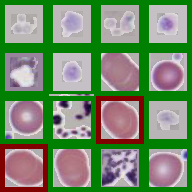

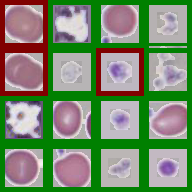

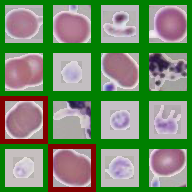

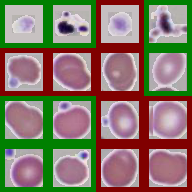

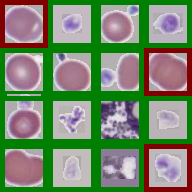

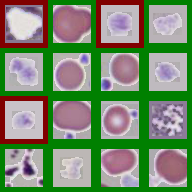

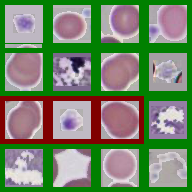

In [56]:
tile_size = 48
n_tiles_x = 4
n_tiles_y = 4
bs = 5
n_positive_image = np.sum(testing_y == 1)
n_negative_image = np.sum(testing_y == 0)
positive_tiles = np.ones([n_tiles_x*tile_size,n_tiles_y*tile_size,3])
count_positive = 0
for c,i in zip(labelled_test_set['classification'],labelled_test_set['cell_idx']):
    c = int(c)
    try:
        if c == 0:
            cell = all_cells[i]
            image = cell['image']
            isolated_image = np.where(cell['isolated_image']>0,1,0.8)
            image = np.uint8(image * isolated_image)
            border_pixels = np.concatenate([image[0,:,:],image[image.shape[0]-1,:,:]])
            border_color = np.uint8(np.mean(border_pixels,axis=0))
            #if np.mean(border_color) < 190:
                #border_color = np.array([210,210,210])
            features = np.array([all_cells[i][f] for f in FF])[np.newaxis,:]
            features = features[:,f_idx[0]:f_idx[1]]
            features = standardized_scaller.transform(features)
            predicted_class = int(fitted_model.predict(features))
            sh = image.shape
            A,C = (tile_size - sh[0])//2,(tile_size - sh[1])//2
            B,D = tile_size - sh[0] - A,tile_size - sh[1] - C
            X = (count_positive // n_tiles_x)*tile_size
            Y = (count_positive % n_tiles_y) *tile_size
            positive_tiles[(X):(X+tile_size),(Y):(Y+tile_size)] = border_color
            positive_tiles[(X+A):(X+tile_size-B),(Y+C):(Y+tile_size-D)] = image
            if predicted_class == c:
                positive_tiles[X:(X+tile_size),Y:(Y+bs)] = [0,128,0]
                positive_tiles[X:(X+tile_size),(Y+tile_size-bs):(Y+tile_size)] = [0,128,0]
                positive_tiles[X:(X+bs),Y:(Y+tile_size)] = [0,128,0]
                positive_tiles[(X+tile_size-bs):(X+tile_size),Y:(Y+tile_size)] = [0,128,0]
            else:
                positive_tiles[X:(X+tile_size),Y:(Y+bs)] = [128,0,0]
                positive_tiles[X:(X+tile_size),(Y+tile_size-bs):(Y+tile_size)] = [128,0,0]
                positive_tiles[X:(X+bs),Y:(Y+tile_size)] = [128,0,0]
                positive_tiles[(X+tile_size-bs):(X+tile_size),Y:(Y+tile_size)] = [128,0,0]
            count_positive += 1

    except:
        pass
    if count_positive == (n_tiles_x * n_tiles_y):
        #positive_tiles[0:30,:,:] = 0
        display(Image.fromarray(positive_tiles.astype(np.uint8)))
        positive_tiles = np.ones([n_tiles_x*tile_size,n_tiles_y * tile_size,3])
        count_positive = 0

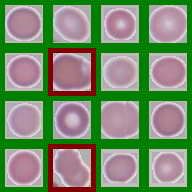

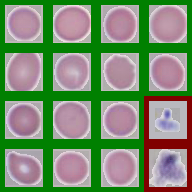

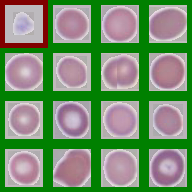

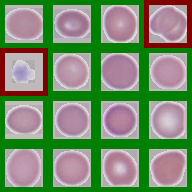

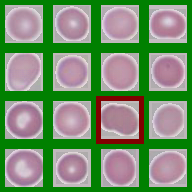

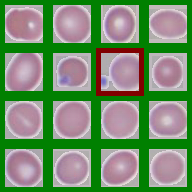

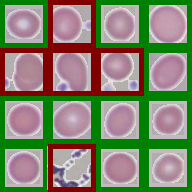

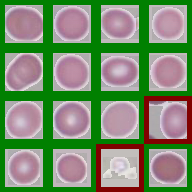

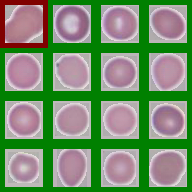

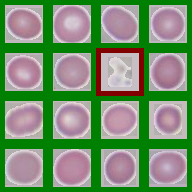

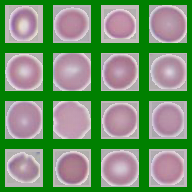

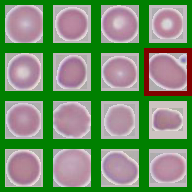

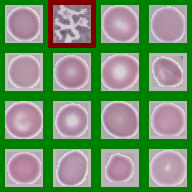

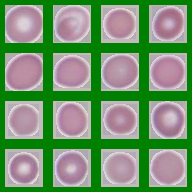

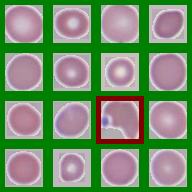

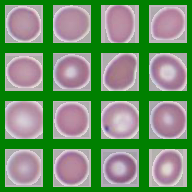

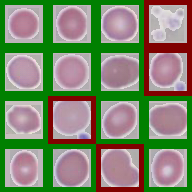

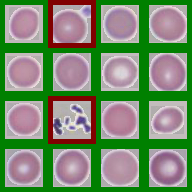

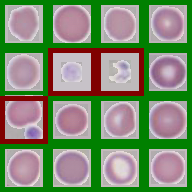

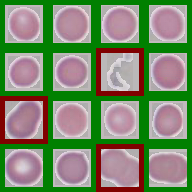

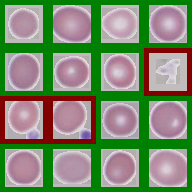

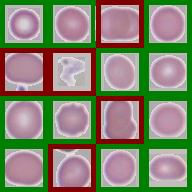

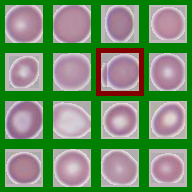

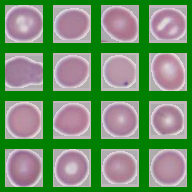

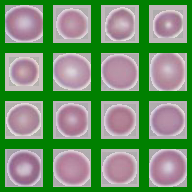

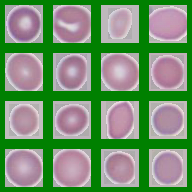

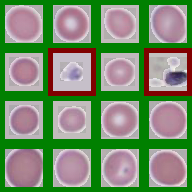

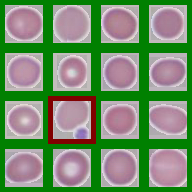

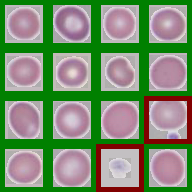

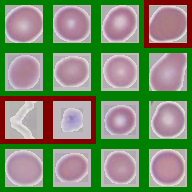

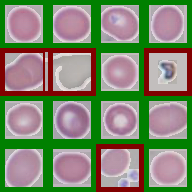

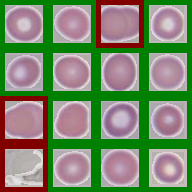

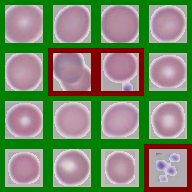

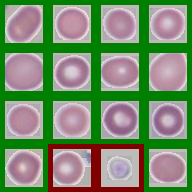

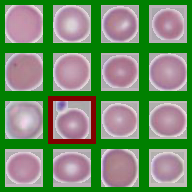

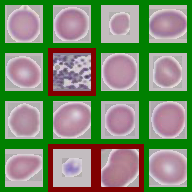

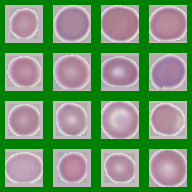

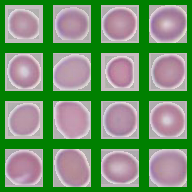

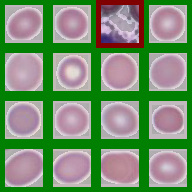

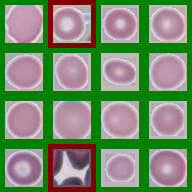

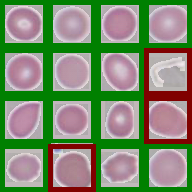

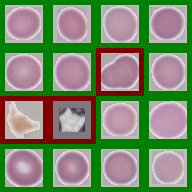

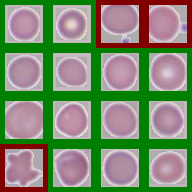

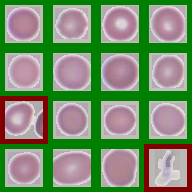

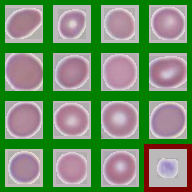

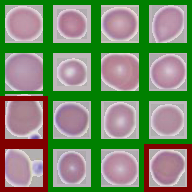

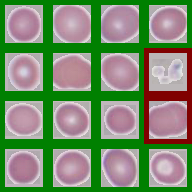

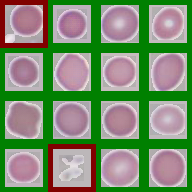

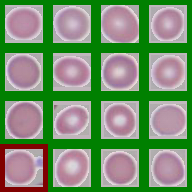

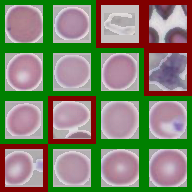

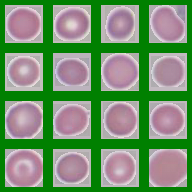

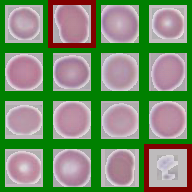

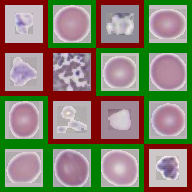

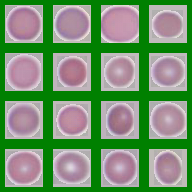

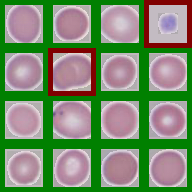

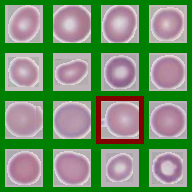

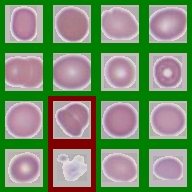

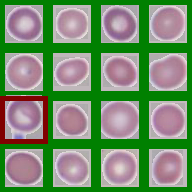

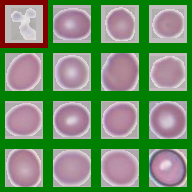

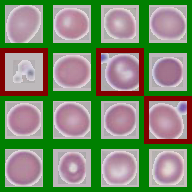

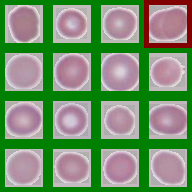

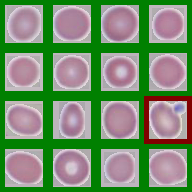

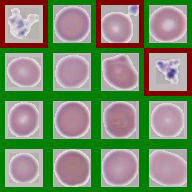

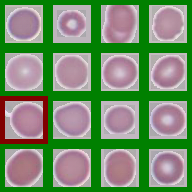

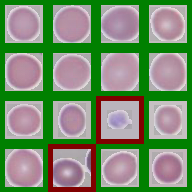

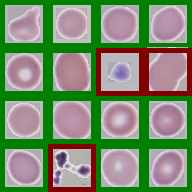

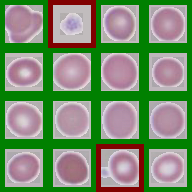

In [46]:
tile_size = 48
n_tiles_x = 4
n_tiles_y = 4
bs = 5
n_positive_image = np.sum(testing_y == 1)
n_negative_image = np.sum(testing_y == 0)
positive_tiles = np.ones([n_tiles_x*tile_size,n_tiles_y*tile_size,3])
count_positive = 0
for c,i in zip(labelled_test_set['classification'],labelled_test_set['cell_idx']):
    c = int(c)
    try:
        cell = all_cells_fan[i]
        image = cell['image']
        isolated_image = np.where(cell['isolated_image']>0,1,0.8)
        image = np.uint8(image * isolated_image)
        border_pixels = np.concatenate([image[0,:,:],image[image.shape[0]-1,:,:]])
        border_color = np.uint8(np.mean(border_pixels,axis=0))
        #if np.mean(border_color) < 190:
            #border_color = np.array([210,210,210])
        features = np.array([all_cells_fan[i][f] for f in FF])[np.newaxis,:]
        features = features[:,f_idx[0]:f_idx[1]]
        features = standardized_scaller.transform(features)
        predicted_class = int(fitted_model.predict(features))
        sh = image.shape
        A,C = (tile_size - sh[0])//2,(tile_size - sh[1])//2
        B,D = tile_size - sh[0] - A,tile_size - sh[1] - C
        X = (count_positive // n_tiles_x)*tile_size
        Y = (count_positive % n_tiles_y) *tile_size
        positive_tiles[(X):(X+tile_size),(Y):(Y+tile_size)] = border_color
        positive_tiles[(X+A):(X+tile_size-B),(Y+C):(Y+tile_size-D)] = image
        if predicted_class == 1:
            positive_tiles[X:(X+tile_size),Y:(Y+bs)] = [0,128,0]
            positive_tiles[X:(X+tile_size),(Y+tile_size-bs):(Y+tile_size)] = [0,128,0]
            positive_tiles[X:(X+bs),Y:(Y+tile_size)] = [0,128,0]
            positive_tiles[(X+tile_size-bs):(X+tile_size),Y:(Y+tile_size)] = [0,128,0]
        else:
            positive_tiles[X:(X+tile_size),Y:(Y+bs)] = [128,0,0]
            positive_tiles[X:(X+tile_size),(Y+tile_size-bs):(Y+tile_size)] = [128,0,0]
            positive_tiles[X:(X+bs),Y:(Y+tile_size)] = [128,0,0]
            positive_tiles[(X+tile_size-bs):(X+tile_size),Y:(Y+tile_size)] = [128,0,0]
        count_positive += 1
        
    except:
        pass
    if count_positive == (n_tiles_x * n_tiles_y):
        #positive_tiles[0:30,:,:] = 0
        display(Image.fromarray(positive_tiles.astype(np.uint8)))
        positive_tiles = np.ones([n_tiles_x*tile_size,n_tiles_y * tile_size,3])
        count_positive = 0

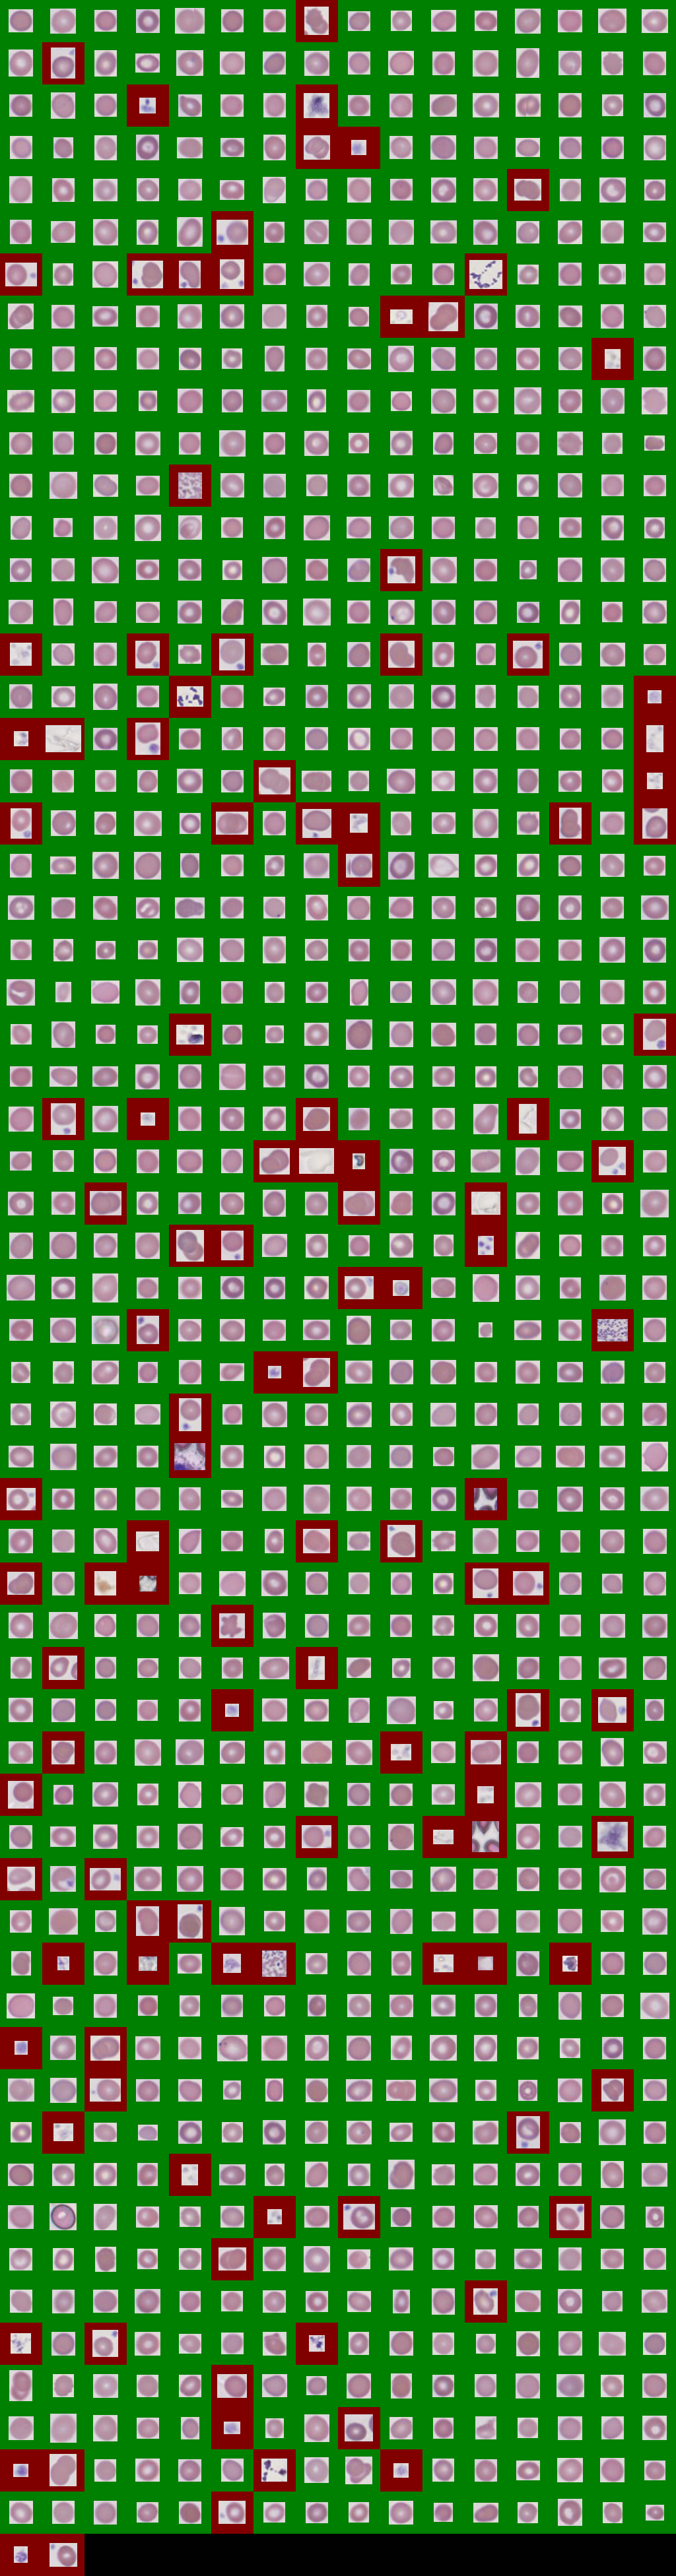

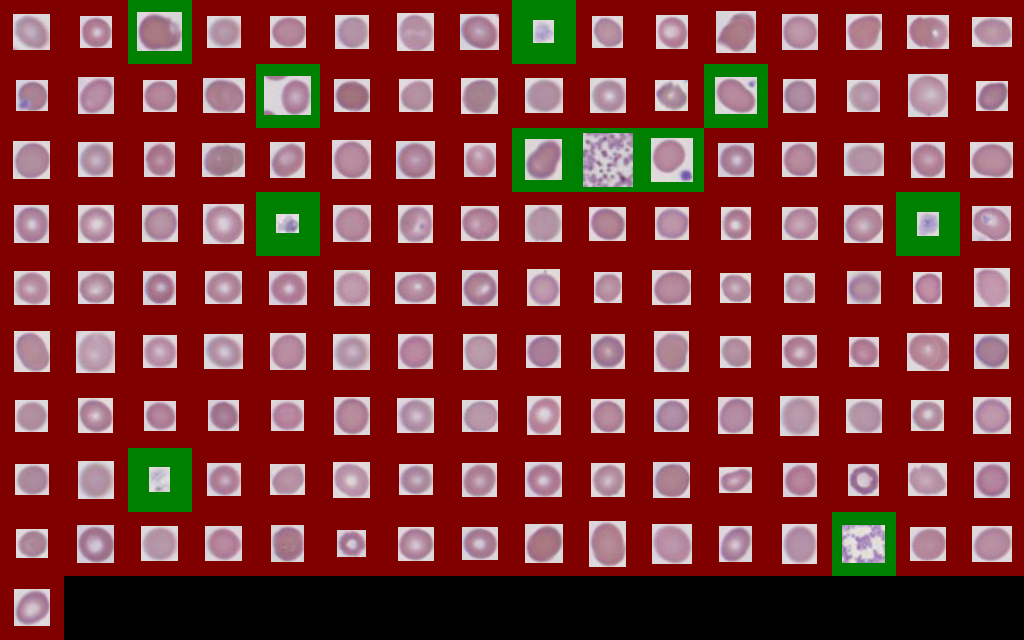

In [40]:
tile_size = 64
n_positive_image = np.sum(testing_y == 1)
n_negative_image = np.sum(testing_y == 0)
positive_tiles = np.ones([(n_positive_image // 16 + 1)*64,16 * 64,3])
negative_tiles = np.ones([(n_negative_image // 16 + 1)*64,16 * 64,3])
count_positive = 0
count_negative = 0
for c,i in zip(labelled_test_set['classification'],labelled_test_set['cell_idx']):
    c = int(c)
    try:
        cell = all_cells_fan[i]
        image = cell['image']
        features = np.array([all_cells_fan[i][f] for f in FF])[np.newaxis,:]
        features = features[:,f_idx[0]:f_idx[1]]
        features = standardized_scaller.transform(features)
        predicted_class = int(fitted_model.predict(features))
        sh = image.shape
        A,C = (tile_size - sh[0])//2,(tile_size - sh[1])//2
        B,D = tile_size - sh[0] - A,tile_size - sh[1] - C
        if c == 1:
            X = (count_positive // 16)*tile_size
            Y = (count_positive % 16) *tile_size
            if predicted_class == c:
                positive_tiles[X:(X+64),Y:(Y+64)] = [0,128,0]
            else:
                positive_tiles[X:(X+64),Y:(Y+64)] = [128,0,0]
            count_positive += 1
            positive_tiles[(X+A):(X+64-B),(Y+C):(Y+64-D)] = image
        if c == 0:
            X = (count_negative // 16)*tile_size
            Y = (count_negative % 16) *tile_size
            if predicted_class == c:
                negative_tiles[X:(X+64),Y:(Y+64)] = [0,128,0]
            else:
                negative_tiles[X:(X+64),Y:(Y+64)] = [128,0,0]
            X = (count_negative // 16)*tile_size
            Y = (count_negative % 16) *tile_size

            count_negative += 1
            negative_tiles[(X+A):(X+64-B),(Y+C):(Y+64-D)] = image
    except:
        pass

display(Image.fromarray(positive_tiles.astype(np.uint8)))

display(Image.fromarray(negative_tiles.astype(np.uint8)))

In [41]:
testing_X = []
testing_y = []
for i,c in zip(labelled_test_set['cell_idx'],labelled_test_set['classification']):
    try:
        testing_X.append([all_cells[i][f] for f in FF])
        if c == '':
            c = '1'
        testing_y.append(int(c))
    except:
        pass
    
testing_X = np.array(testing_X)[:,f_idx[0]:f_idx[1]]
testing_y = np.array(testing_y).astype(np.bool)
testing_X = standardized_scaller.transform(testing_X)
testing_y = testing_y[~np.any(np.isnan(testing_X),axis=1)]
testing_X = testing_X[~np.any(np.isnan(testing_X),axis=1),:]
predictions = fitted_model.predict(testing_X)

tsne = TSNE(2)
tsne_transf = tsne.fit_transform(testing_X)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


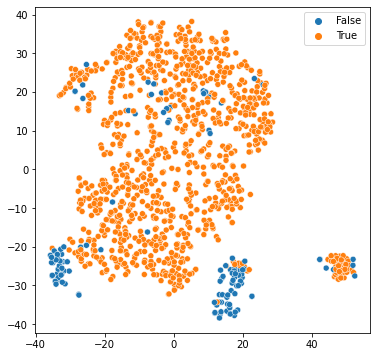

In [42]:
rcParams['figure.figsize'] = 6, 6

sb.scatterplot(tsne_transf[:,0],tsne_transf[:,1],
               hue=predictions)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


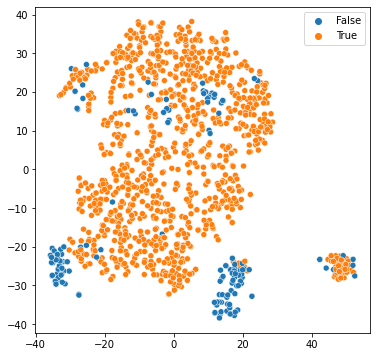

In [43]:
sb.scatterplot(tsne_transf[:,0],tsne_transf[:,1],
               hue=testing_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


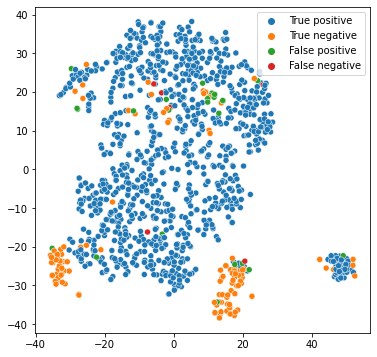

In [44]:
def translate(t,p):
    if t == 1:
        if t == p:
            return "True positive"
        else:
            return "False negative"
    else:
        if t == p:
            return "True negative"
        else:
            return "False positive"

sb.scatterplot(tsne_transf[:,0],tsne_transf[:,1],
               hue=[translate(a,b) for a,b in zip (testing_y,predictions)])

[ True]


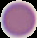

[ True]


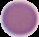

[ True]


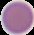

[ True]


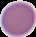

[ True]


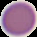

[False]


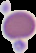

[False]


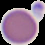

[ True]


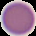

[ True]


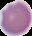

In [45]:
# for paper

image = io.imread("slide38_small.jpg")

image = cv2.resize(image,tuple([int(x / 2) for x in [image.shape[1],image.shape[0]]]))
features = fn(image)
contours = np.where(mask_rbc(image)[1] > 0,1.0,0.5)

Image.fromarray(np.uint8(image * contours)).save(
    "slide38_small_rbc_merge.png"
)

for cell in features:
    F = [cell[f] for f in FF]
    F = np.array(F)[np.newaxis,f_idx[0]:f_idx[1]]
    c = fitted_model.predict(standardized_scaller.transform(F))    
    print(c)
    display(Image.fromarray(cell['isolated_image'].astype(np.uint8)))